# Quantifying Permafrost-Related Ground Feformation with InSAR Time Series Using HyP3 Products and MintPy

![SAR, InSAR, PolSAR, and banner](https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/blackboard-banner.png)

The main purpose is to quantifying permafrost-related ground deformation in a local scale.

**Author:** Jie Chen; University of Alaska Fairbanks

Based on the InSAR Time Series Analysis using MintPy and HyP3 products, Alex Lewandowski; University of Alaska Fairbanks.

Based on the [LosAngeles_time_series](https://github.com/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Hazards/LosAngeles_time_series.ipynb) notebook by Eric Fielding, David Bekaert, Heresh Fattahi and Yunjun Zhang, which uses an example ARIA dataset.

# 0: Notebook setup

**Import necessary packages**

In [1]:
import numpy as np

import os
from getpass import getpass
from pathlib import Path
from typing import Union
# from ipyfilechooser import FileChooser

# diff behavior based on mintpy <= 1.4.1 or > 1.4.1
from importlib.metadata import version as getVersion
from packaging import version as compareVersion
isLatest = compareVersion.parse(getVersion('mintpy')) > compareVersion.parse('1.4.1')

# MintPy ver beyond 1.4.1
if isLatest:
    from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
# MintPy <= 1.4.1 (old)
else:
    import mintpy.view as view
    import mintpy.tsview as tsview
    import mintpy.plot_network as plot_network
    import mintpy.plot_transection as plot_transection
    import mintpy.plot_coherence_matrix as plot_coherence_matrix

import mintpy.plot_coherence_matrix
from mintpy.utils import readfile, writefile
import mintpy.objects.insar_vs_gps
import mintpy.utils

import opensarlab_lib as asfn

import h5py
import rasterio
import datetime
from tqdm.notebook import tqdm

**Download and unzip the prepared dataset**

In [2]:
home = Path.home()
zip_pth = home/"insar_sbas_permafrost_chen.zip"
work_path = home/"insar_sbas_permafrost_chen"
if not work_path.exists():
    !aws s3 cp --no-sign-request s3://asf-jupyter-data-west/jie_chen/insar_sbas_permafrost_chen.zip {zip_pth}
    !unzip {zip_pth} -d {home}
    zip_pth.unlink()

download: s3://asf-jupyter-data-west/jie_chen/insar_sbas_permafrost_chen.zip to ../insar_sbas_permafrost_chen.zip
Archive:  /home/jovyan/insar_sbas_permafrost_chen.zip
   creating: /home/jovyan/insar_sbas_permafrost_chen/
   creating: /home/jovyan/insar_sbas_permafrost_chen/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022/
  inflating: /home/jovyan/insar_sbas_permafrost_chen/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022_lv_theta_clip.tif  
  inflating: /home/jovyan/insar_sbas_permafrost_chen/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022_dem_clip.tif.rsc  
  inflating: /home/jovyan/insar_sbas_permafrost_chen/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022/S1AA_20220614T173346_20220720T173348_VVP036_INT80_G_weF_0022_corr_clip.tif  
  inflating: /home/jovyan/insar_sbas_permafrost_chen/S1AA_20220614T173346_20220720T

**Define a project name and create a MintPy directory in which to store files output during our analysis**

In [3]:
print(f"Work directory: {work_path}")

# InSAR data path
insar_data = work_path
print(f"InSAR data directory: {insar_data}")

# define a project name (for Sentinel-1 data, the name should start with "Sen_")
proj_name = 'Sen_mintpy_config'

# define the MintPy time-series directory
mint_path = work_path/f'MintPy_sbas'
mint_path.mkdir(exist_ok=True)
print(f"MintPy directory: {mint_path}")

#create a directory in which to store plots
plot_path = mint_path/"plots"
plot_path.mkdir(exist_ok=True)

Work directory: /home/jovyan/insar_sbas_permafrost_chen
InSAR data directory: /home/jovyan/insar_sbas_permafrost_chen
MintPy directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas


# 1. Add Your Climate Data Store (CDS) UID & API Key to the Pyaps3 Config 

### This step only needs to be completed once and may be skipped if you have already updated the CDS config 

- Running the MintPy smallbaselineApp's `correct_troposphere` step requires downloading atmospheric pressure data from the CDS
- If don't yet have a CDS API key:
    - Proceed to [CDS](https://cds.climate.copernicus.eu/cdsapp#!/home) and create an account
    - Open the [Datasets page](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset)
    - Search for "ERA5"
    - Select any of ERA5 datasets that appear
    - Select the `Download data` tab
    - Scroll to the bottom of the screen
    - Accept the `Terms of use`
    - Click on your name at the top right of the screen to access your profile page
    - Your `UID` and `API Key` will be displayed here 
- Run the following 2 code cells to update the pyaps config from this notebook **OR** open an OpenSARlab terminal and complete the following steps:
    - Use vim or another text editor to open the `~/.cdsapirc` config file
        - Add the CDS url to the first line of the config and your CDS `UID` and CDS`API Key` to the 2nd line of the config
            - This should be formatted like:
                - url: https://cds.climate.copernicus.eu/api/v2\
                - your_UID: your_API_Key
        - Save the config and exit the text editor

**If you do not add your CDS credentials to `~/.cdsapirc`, the `correct_troposphere` step will fail**

In [4]:
pyaps_cfg = Path("/home/jovyan/.cdsapirc")
try:
    with open(pyaps_cfg, 'r') as f:
        lines = f.readlines()
        if len(lines) == 2 and 'url' in lines[0]:
            print("There was a CDS UID and API Key found in the pyaps3 config: ~/.cdsapirc")
            print("Would you like to update them?")
            update_cds_cfg = asfn.select_parameter(["Do not update CDS UID and API Key", 
                                                    "Update CDS UID and API Key"])
            display(update_cds_cfg)
        else:
            update_cds_cfg = None
except FileNotFoundError:
    update_cds_cfg = None
    

There was a CDS UID and API Key found in the pyaps3 config: ~/.cdsapirc
Would you like to update them?


RadioButtons(layout=Layout(min_width='800px'), options=('Do not update CDS UID and API Key', 'Update CDS UID a…

In [5]:
if not update_cds_cfg or "Update" in update_cds_cfg.value:
    with open(pyaps_cfg, 'w') as f:
            uid = input("Enter your CDS UID")
            key = getpass("Enter your CDS API Key")
            lines = ['', '']
            lines[0] = f"url: https://cds.climate.copernicus.eu/api/v2\n"
            lines[1] = f"key: {uid}:{key}\n"
            f.seek(0)
            f.writelines(lines)
            f.truncate()
            

# 2. smallbaselineApp.py overview

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries.  
The workflow consists of two main blocks:

* correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through some of these steps, for a complete example see the [MintPy repository](https://github.com/insarlab/MintPy).


<p align="left">
  <img width="600" src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/MintPyWorkflow.jpg">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 2.1. Processing steps of smallbaselineApp.py

The MintPy **smallbaselineApp.py** application provides a workflow to invert a stack of unwrapped interferograms and apply different (often optional) corrections to obtain ground displacement timeseries. A detailed overview of the options can be retrieved by involking the help option:

## 2.2. Configuring processing parameters

The processing parameters for the **smallbaselineApp.py** are controlled through a configuration file. If no file is provided the default [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg) configuration is used. We will create a custom config file with modified configuration parameters for this time-series analysis. Any options added to the custom config will override options set in the default config.

In [6]:
# Configure the parameters
insar_processer = 'hyp3'

# Selecting InSAR data
# insar_data_subset = f'{insar_data}/*_{year}????T*_{year}????T*'
insar_data_subset = f'{insar_data}/*'

# Define the start and end date for interferogram pairs
start_date = 'auto'
end_date = 'auto'

network_coh = 0.6

reference_date = '20210607'
ref_latlon = [7529873,522376]

inverse_weight_method = 'var'
inverse_temporal_coh = 0.6
tropospheric_delay_method = 'pyaps'
deramp_method = 'linear'

defo_model_polynomial = 1       # auto for 1, degree of the polynomial function
defo_model_periodic = 1         # auto for no, periods in decimal years
cpu_count = os.cpu_count()    

In [7]:
config = f'''# vim: set filetype=cfg:
##------------------------ smallbaselineApp.cfg ------------------------##
########## computing resource configuration
mintpy.compute.maxMemory = auto #[float > 0.0], auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all of locally available cores (for cluster = local only)
## numWorker = 80%  to use 80% of locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = {cpu_count} #[int > 1 / all / num%], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers

########## 1. load_data
mintpy.load.processor       = {insar_processer}  #[isce, aria, hyp3, gmtsar, snap, gamma, roipac], auto for isce

##---------interferogram stack:
mintpy.load.unwFile          = {insar_data_subset}/*unw_phase_clip.tif
mintpy.load.corFile          = {insar_data_subset}/*corr_clip.tif

##---------geometry:
mintpy.load.demFile          = {insar_data_subset}/*dem_clip.tif
mintpy.load.incAngleFile     = {insar_data_subset}/*lv_theta_clip.tif
mintpy.load.azAngleFile      = {insar_data_subset}/*lv_phi_clip.tif
mintpy.load.waterMaskFile    = {insar_data_subset}/*water_mask_clip.tif

##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
mintpy.subset.yx            = auto    #[y0:y1,x0:x1 / no], auto for no
mintpy.subset.lalo          = auto    #[S:N,W:E / no], auto for no
# mintpy.subset.lalo          = [7507787:7545857, 495449:548058]    #[S:N,W:E / no], auto for no


########## 2. modify_network
## 1) Network modification based on temporal/perpendicular baselines, date, num of connections etc.
mintpy.network.tempBaseMax     = auto  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.perpBaseMax     = auto  #[1-inf, no], auto for no, max perpendicular spatial baseline in meter
mintpy.network.connNumMax      = auto  #[1-inf, no], auto for no, max number of neighbors for each acquisition
mintpy.network.startDate       = {start_date}  #[20090101 / no], auto for no
mintpy.network.endDate         = {end_date}  #[20110101 / no], auto for no
mintpy.network.excludeDate     = auto  #[20080520,20090817 / no], auto for no
mintpy.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)

## 2) Data-driven network modification
## a - Coherence-based network modification = (threshold + MST) by default
## reference: Yunjun et al. (2019, section 4.2 and 5.3.1); Chaussard et al. (2015, GRL)
## It calculates a average coherence for each interferogram using spatial coherence based on input mask (with AOI)
## Then it finds a minimum spanning tree (MST) network with inverse of average coherence as weight (keepMinSpanTree)
## Next it excludes interferograms if a) the average coherence < minCoherence AND b) not in the MST network.
mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = {network_coh}  #[0.0-1.0], auto for 0.7

## b - Effective Coherence Ratio network modification = (threshold + MST) by default
## reference: Kang et al. (2021, RSE)
## It calculates the area ratio of each interferogram that is above a spatial coherence threshold.
## This threshold is defined as the spatial coherence of the interferograms within the input mask.
## It then finds a minimum spanning tree (MST) network with inverse of the area ratio as weight (keepMinSpanTree)
## Next it excludes interferograms if a) the area ratio < minAreaRatio AND b) not in the MST network.
mintpy.network.areaRatioBased  = no  #[yes / no], auto for no, exclude interferograms with area ratio < minAreaRatio
mintpy.network.minAreaRatio    = 0.8  #[0.0-1.0], auto for 0.75

########## 3. reference_point
## Reference all interferograms to one common point in space
## auto - randomly select a pixel with coherence > minCoherence
## however, manually specify using prior knowledge of the study area is highly recommended
##   with the following guideline (section 4.3 in Yunjun et al., 2019):
## 1) located in a coherence area, to minimize the decorrelation effect.
## 2) not affected by strong atmospheric turbulence, i.e. ionospheric streaks
## 3) close to and with similar elevation as the AOI, to minimize the impact of spatially correlated atmospheric delay
mintpy.reference.yx            = auto   #[257,151 / auto]
mintpy.reference.lalo          = {ref_latlon}   #[31.8,130.8 / auto]

########## 4. correct_unwrap_error (optional)
## connected components (mintpy.load.connCompFile) are required for this step.
## SNAPHU (Chem & Zebker,2001) is currently the only unwrapper that provides connected components as far as we know.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure          - suitable for highly redundant network
## b. bridging               - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
## c. bridging+phase_closure - recommended when there is a small percentage of errors left after bridging
mintpy.unwrapError.method          = no  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]
mintpy.unwrapError.connCompMinArea = auto  #[1-inf], auto for 2.5e3, discard regions smaller than the min size in pixels


########## 5. invert_network
## Invert network of interferograms into time-series using weighted least sqaure (WLS) estimator.
## weighting options for least square inversion [fast option available but not best]:
## a. var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
## b. fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
## c. coh - use coherence as weight (Perissin & Wang, 2012)
## d. no  - uniform weight (Berardino et al., 2002) [fast]
## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
mintpy.networkInversion.weightFunc      = {inverse_weight_method} #[var / fim / coh / no], auto for var
mintpy.networkInversion.waterMaskFile   = auto #[filename / no], auto for waterMask.h5 or no [if not found]
mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity / phase

## mask options for unwrapPhase of each interferogram before inversion (recommend if weightFunct=no):
## a. coherence              - mask out pixels with spatial coherence < maskThreshold
## b. connectComponent       - mask out pixels with False/0 value
## c. no                     - no masking [recommended].
## d. range/azimuthOffsetStd - mask out pixels with offset std. dev. > maskThreshold [for offset]
mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / rangeOffsetStd / azimuthOffsetStd / no], auto for no
mintpy.networkInversion.maskThreshold = auto #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition

## Temporal coherence is calculated and used to generate the mask as the reliability measure
## reference: Pepe & Lanari (2006, IEEE-TGRS)
mintpy.networkInversion.minTempCoh  = {inverse_temporal_coh} #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.networkInversion.minNumPixel = auto #[int > 1], auto for 100, min number of pixels in mask above
mintpy.networkInversion.shadowMask  = auto #[yes / no], auto for yes [if shadowMask is in geometry file] or no.

########## 6. correct_troposphere (optional but recommended)
## correct tropospheric delay using the following methods:
## a. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
## b. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011; 2014)
##      ERA5  - ERA5    from ECMWF [need to install PyAPS from GitHub; recommended and turn ON by default]
##      MERRA - MERRA-2 from NASA  [need to install PyAPS from Caltech/EarthDef]
##      NARR  - NARR    from NOAA  [need to install PyAPS from Caltech/EarthDef; recommended for N America]
## c. gacos - use GACOS with the iterative tropospheric decomposition model (Yu et al., 2018, JGR)
##      need to manually download GACOS products at http://www.gacos.net for all acquisitions before running this step
mintpy.troposphericDelay.method = {tropospheric_delay_method}  #[pyaps / height_correlation / gacos / no], auto for pyaps

## Notes for pyaps:
## a. GAM data latency: with the most recent SAR data, there will be GAM data missing, the correction
##    will be applied to dates with GAM data available and skipped for the others.
## b. WEATHER_DIR: if you define an environment variable named WEATHER_DIR to contain the path to a
##    directory, then MintPy applications will download the GAM files into the indicated directory.
##    MintPy application will look for the GAM files in the directory before downloading a new one to
##    prevent downloading multiple copies if you work with different dataset that cover the same date/time.
mintpy.troposphericDelay.weatherModel = ERA5  #[ERA5 / MERRA / NARR], auto for ERA5
mintpy.troposphericDelay.weatherDir   = auto  #[path2directory], auto for WEATHER_DIR or "./"

########## 7. deramp (optional)
## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
mintpy.deramp          = {deramp_method}  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation


########## 8. correct_topography (optional but recommended)
## Topographic residual (DEM error) correction
## reference: Fattahi and Amelung (2013, IEEE-TGRS)
## stepFuncDate      - specify stepFuncDate option if you know there are sudden displacement jump in your area,
##                     e.g. volcanic eruption, or earthquake
## excludeDate       - dates excluded for the error estimation
## pixelwiseGeometry - use pixel-wise geometry (incidence angle & slant range distance)
##                     yes - use pixel-wise geometry if they are available [slow; used by default]
##                     no  - use the mean   geometry [fast]
mintpy.topographicResidual                   = yes  #[yes / no], auto for yes
mintpy.topographicResidual.polyOrder         = auto  #[1-inf], auto for 2, poly order of temporal deformation model
mintpy.topographicResidual.phaseVelocity     = auto  #[yes / no], auto for no - use phase velocity for minimization
mintpy.topographicResidual.stepFuncDate      = auto  #[20080529,20190704T1733 / no], auto for no, date of step jump
mintpy.topographicResidual.excludeDate       = auto  #[20070321 / txtFile / no], auto for exclude_date.txt
mintpy.topographicResidual.pixelwiseGeometry = auto  #[yes / no], auto for yes, use pixel-wise geometry info


########## 9.1 residual_RMS (root mean squares for noise evaluation)
## Calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
## reference: Yunjun et al. (2019, section 4.9 and 5.4)
## To get rid of long spatial wavelength component, a ramp is removed for each acquisition
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
mintpy.residualRMS.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
mintpy.residualRMS.cutoff   = auto  #[0.0-inf], auto for 3

########## 9.2 reference_date
## Reference all time-series to one date in time
## reference: Yunjun et al. (2019, section 4.9)
## no     - do not change the default reference date (1st date)
mintpy.reference.date = {reference_date}   #[reference_date.txt / 20090214 / no], auto for reference_date.txt


########## 10. velocity
## Estimate a suite of time functions [linear velocity by default]
## from final displacement file (and from tropospheric delay file if exists)
mintpy.timeFunc.startDate   = auto   #[20070101 / no], auto for no
mintpy.timeFunc.endDate     = auto   #[20101230 / no], auto for no
mintpy.timeFunc.excludeDate = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt

## Fit a suite of time functions
## reference: Hetland et al. (2012, JGR) equation (2-9)
## polynomial function    is  defined by its degree in integer. 1 for linear, 2 for quadratic, etc.
## periodic   function(s) are defined by a list of periods in decimal years. 1 for annual, 0.5 for semi-annual, etc.
## step       function(s) are defined by a list of onset times in str in YYYYMMDD(THHMM) format
## exp & log  function(s) are defined by an onset time followed by an charateristic time in integer days.
##   Multiple exp and log functions can be overlaied on top of each other, achieved via e.g.:
##   20110311,60,120          - two functions sharing the same onset time OR
##   20110311,60;20170908,120 - separated by ";"
mintpy.timeFunc.polynomial = {defo_model_polynomial}   #[int >= 0], auto for 1, degree of the polynomial function
mintpy.timeFunc.periodic   = {defo_model_periodic}   #[1,0.5 / list_of_float / no], auto for no, periods in decimal years
mintpy.timeFunc.stepDate   = auto   #[20110311,20170908 / 20120928T1733 / no], auto for no, step function(s)
mintpy.timeFunc.exp        = auto   #[20110311,60 / 20110311,60,120 / 20110311,60;20170908,120 / no], auto for no
mintpy.timeFunc.log        = auto   #[20110311,60 / 20110311,60,120 / 20110311,60;20170908,120 / no], auto for no

## Uncertainty quantification methods:
## a. residue    - propagate from fitting residue assuming normal dist. in time (Fattahi & Amelung, 2015, JGR)
## b. covariance - propagate from time series (co)variance matrix
## c. bootstrap  - bootstrapping (independently resampling with replacement; Efron & Tibshirani, 1986, Stat. Sci.)
mintpy.timeFunc.uncertaintyQuantification = auto   #[residue, covariance, bootstrap], auto for residue
mintpy.timeFunc.timeSeriesCovFile         = auto   #[filename / no], auto for no, time series covariance file
mintpy.timeFunc.bootstrapCount            = auto   #[int>1], auto for 400, number of iterations for bootstrapping

mintpy.plot           = no  #[yes / no], auto for yes, plot files generated by default processing to pic folder
'''

In [8]:
config_path = mint_path/f'{proj_name}.txt'
# updated_config = f'{config}{multithread_config}'
with open(config_path, 'w') as f:
    f.write(config)
    print(f"config file path: {config_path}\n")

config file path: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt



# 3. Small Baseline Time Series Analysis

**You can run every step in smallbaselineApp.py with one call, using the command in the cell below**

**For the purposes of this tutorial, we will run each step separately**

We will run the steps:
- load_data
- modify_network
- reference_point
- quick_overview
- invert_network
- correct_troposphere
- correct_topography
- residual_RMS
- reference_date
- velocity
- google_earth

Skipped steps include:
- correct_unwrap_error
- correct_LOD
- correct_SET
- deramp
- hdfeos5

Skipped steps will also be skipped if running the entire smallbaselineApp in the cell below.

## 3.1. Load Data

**Run the `load_data` step**

- If you get a missing 'Height' attribute error, you are missing a DEM, which is an available option when ordering HyP3 InSAR products


In [ ]:
# All-in-one step
# !smallbaselineApp.py $config_path --work-dir {mint_path} --start load_data --end velocity

In [9]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:47:24.023187--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
copy default template file /home/jovyan/.local/envs/NISAR_EA_Workshop_2024_1/lib/python3.9/site-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
    mintpy.comp

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.). 

In [10]:
inputs_path = mint_path/'inputs'
!ls $inputs_path
!info.py $inputs_path/ifgramStack.h5

geometryGeo.h5	ifgramStack.h5	Sen_mintpy_config.txt  smallbaselineApp.cfg
******************** Basic File Info ************************
file name: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          4
  ANTENNA_SIDE                                    -1
  AZIMUTH_PIXEL_SIZE                              56.4
  BANDS                                           1
  CENTER_LINE_UTC                                 63219.78022
  DATA_TYPE                                       float32
  DATE12                                          210607-210619
  EARTH_RADIUS                                    6360041.1870
  EPSG                                            32603
  FILE_LENGTH                                     125
  FILE_PATH                                       /home/jovyan/insar_sbas_permafros

<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>

## 3.2. Modify the Network

**Run the `modify_network` step**

- Identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion

In [11]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep modify_network

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:47:33.185878--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy

## 3.3. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read temporal/spatial baseline info from file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['/home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 21
number of interferograms: 71
shift all perp baseline by -19.971574783325195 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 23
number of interferograms marked as keep: 48
number of acquisitions marked as drop: 0
max coherence of excluded interferograms: 0.5741
max perpendicular baseline: 168.40 m
max temporal      baseline: 372.0 days
showing coherence
data range: [0.2921, 0.9633]
display range: [0.0, 0.55]
showing ...


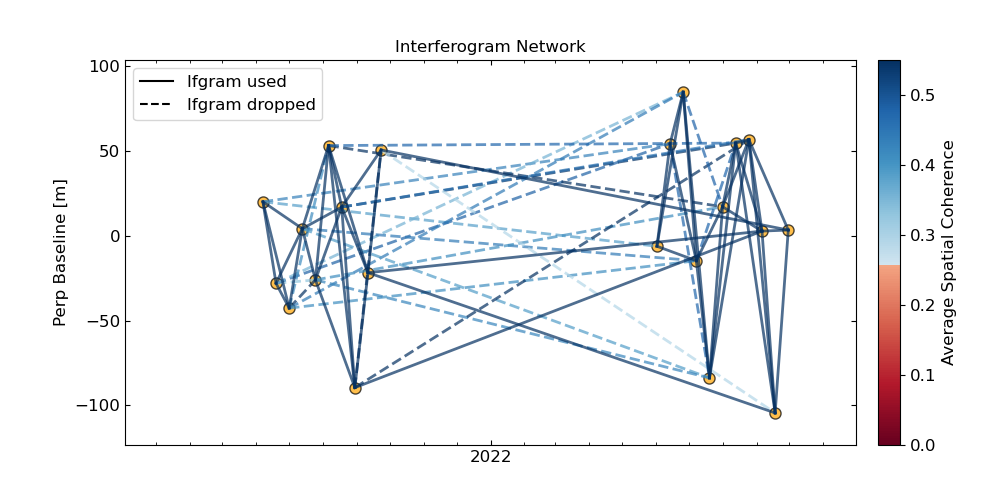

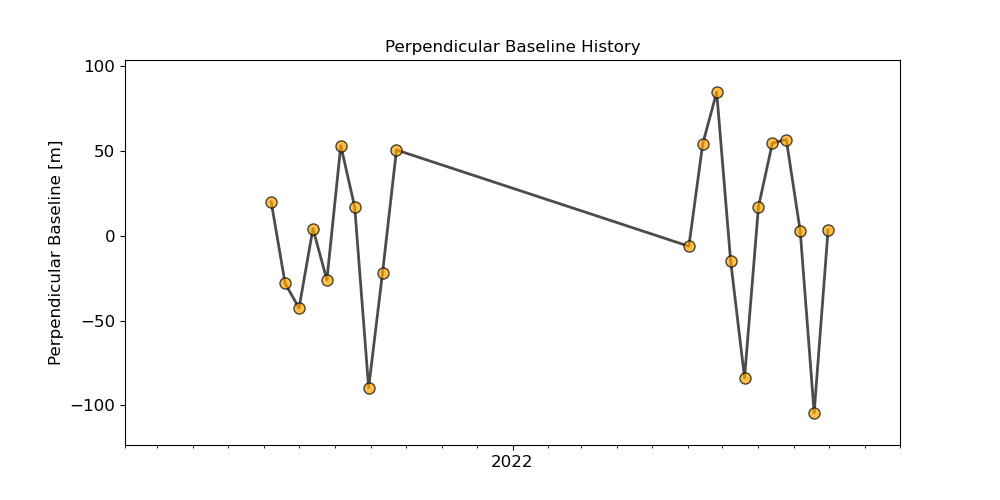

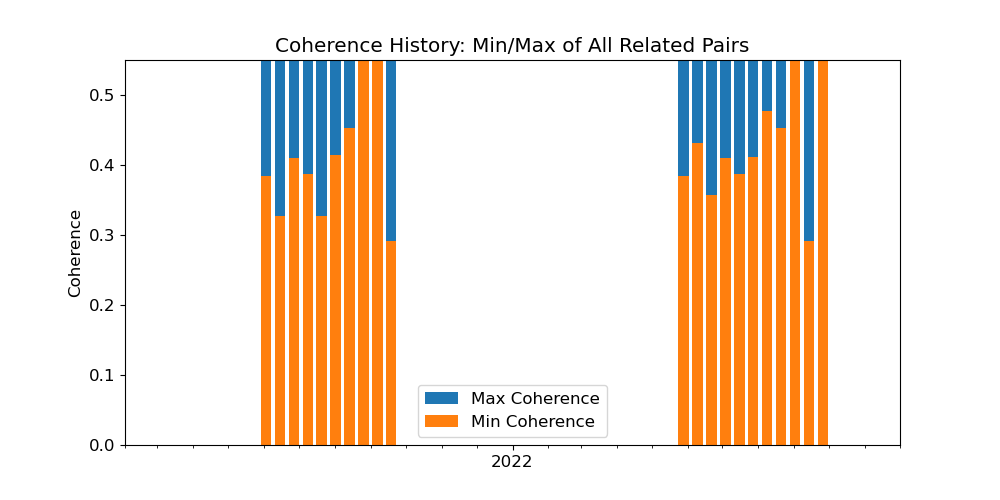

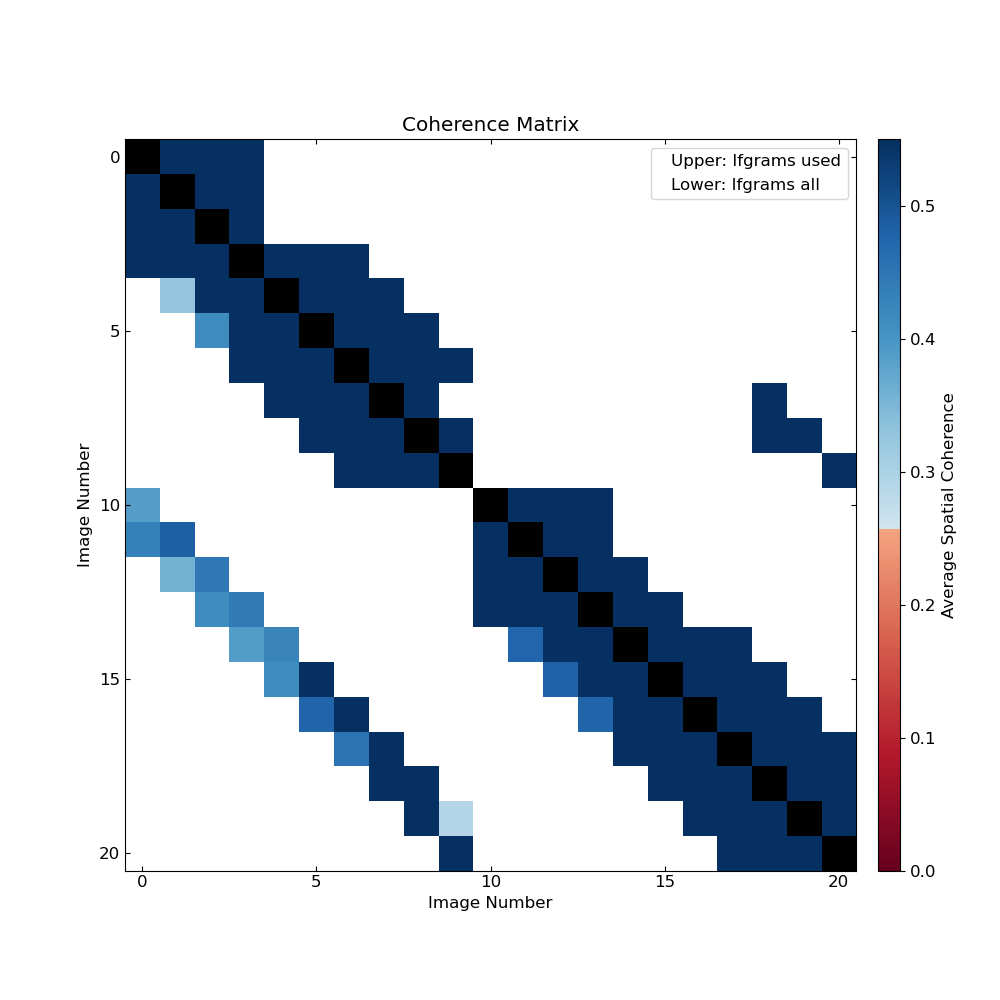

In [12]:
%matplotlib widget
with asfn.work_dir(mint_path):
    plot_network.main((f'{inputs_path}/ifgramStack.h5 -v 0 0.55 --figsize 10 5').split())
    plots = ['bperpHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']
    for p in plots:
        if (mint_path/p).exists():
            (mint_path/p).rename(f'{plot_path}/{p}')

## 3.4. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.   

In [13]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_point

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:47:42.763403--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselin

## 3.5. Mannually check all the interferograms

view.py /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/ifgramStack.h5 unwrapPhase-* -v -6 6 --zero-mask --noaxis --noverbose --figsize 10 8


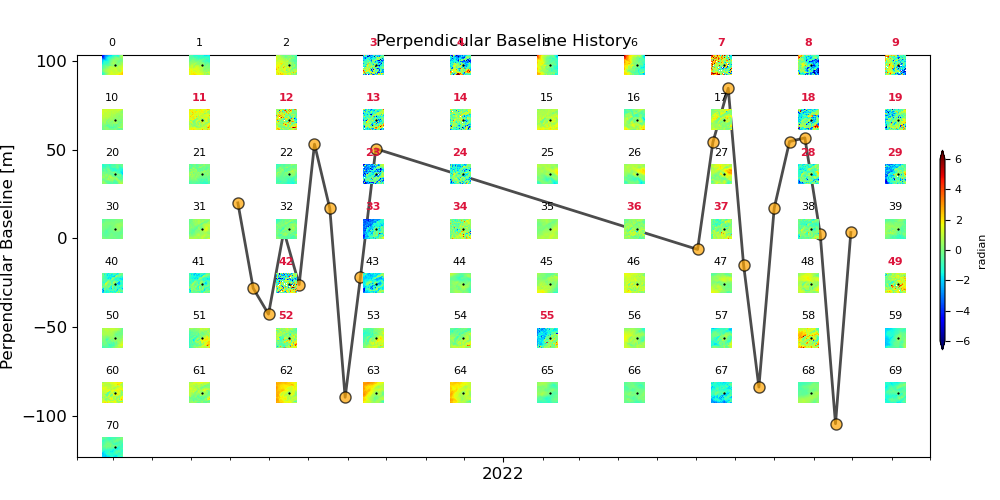

In [14]:
%matplotlib widget
view.main(f'{inputs_path}/ifgramStack.h5 unwrapPhase-* -v -6 6 --zero-mask --noaxis --noverbose --figsize 10 8'.split())
# view.main(f'{inputs_path}/ifgramStack.h5 coherence-* -v 0 0.9 --zero-mask --noaxis --noverbose --figsize 10 8'.split())

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

In [15]:
!info.py $inputs_path/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                                         7529880.0
  REF_LON                                         522360.0
  REF_X                                           80
  REF_Y                                           64


## 3.6. Run a Quick Overview

**Run the `quick_overview` step**

- Assess possible groud deformation using the velocity from traditional interferogram stacking 
    - *reference: Zebker et al. (1997, JGR)*
- Assess distribution of phase unwrapping error from the number of interferogram triplets with non-zero integer ambiguity of closure phase 
    - *reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.*

In [16]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep quick_overview

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:47:56.935674--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg


********

## 3.6. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters. 

In [17]:
ifgram_path = mint_path/"inputs/ifgramStack.h5"

In [18]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep invert_network

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:48:02.377913--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg


******************** step - invert_network *******

calculate the temporal average of coherence in file /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/ifgramStack.h5 ...
[==================================================] lines 125/125    0s /     0s
delete exsited file: avgSpatialCoh.h5
create HDF5 file: avgSpatialCoh.h5 with w mode
create dataset /coherence of float32    in size of (125, 125)           with compression=None
finished writing to avgSpatialCoh.h5
time used: 00 mins 0.0 secs

view.py avgSpatialCoh.h5 --noverbose


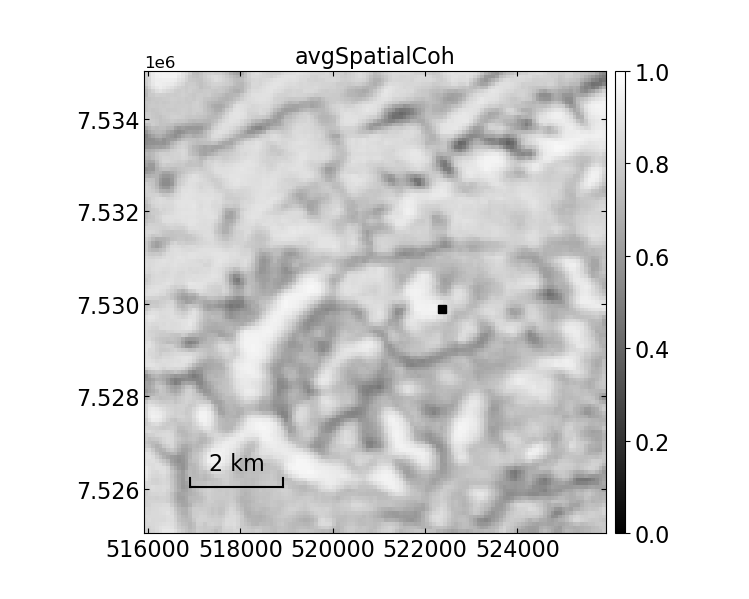

In [19]:
!temporal_average.py $inputs_path/ifgramStack.h5 -d coherence -o avgSpatialCoh.h5
view.main('avgSpatialCoh.h5 --noverbose'.split())
# equivalent command in terminal: view.py avgSpatialCoh.h5 --noverbose

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is temporalCoherence file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/temporalCoherence.h5 in float32 format
file size in y/x: (125, 125)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.79279655, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
save figure to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/plots

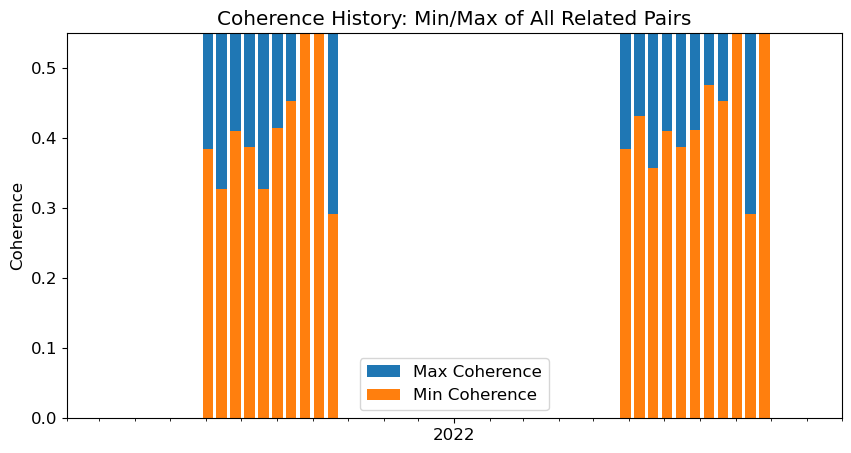

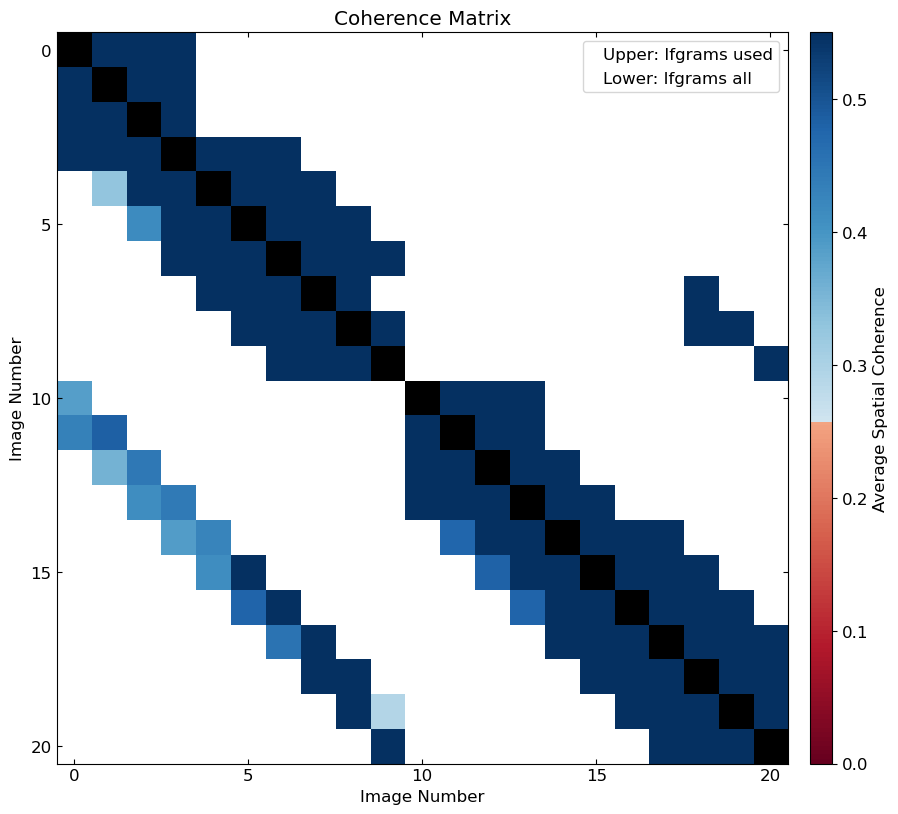

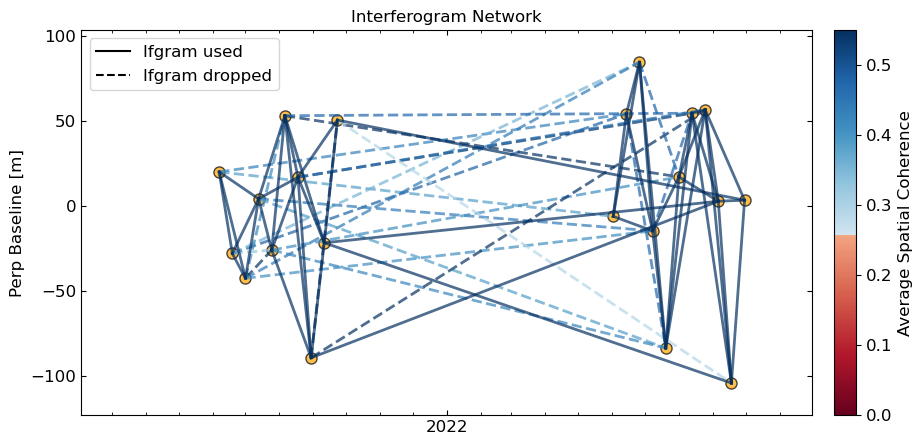

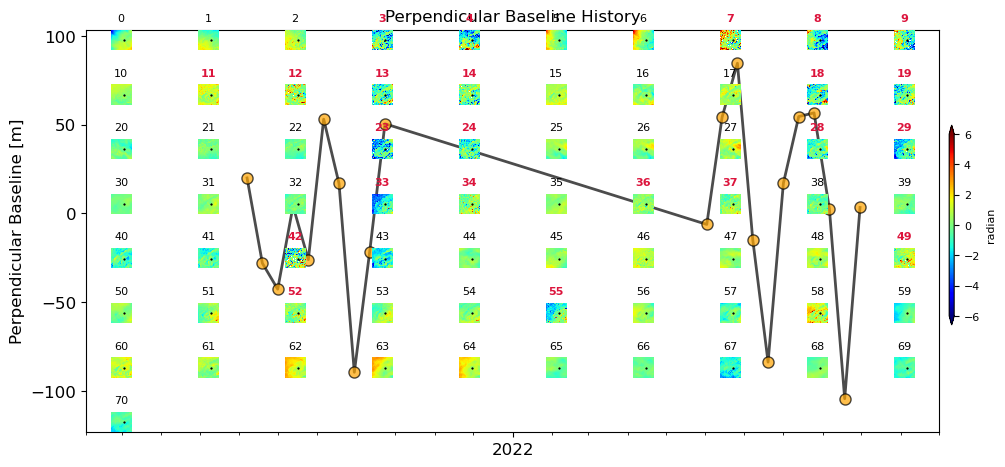

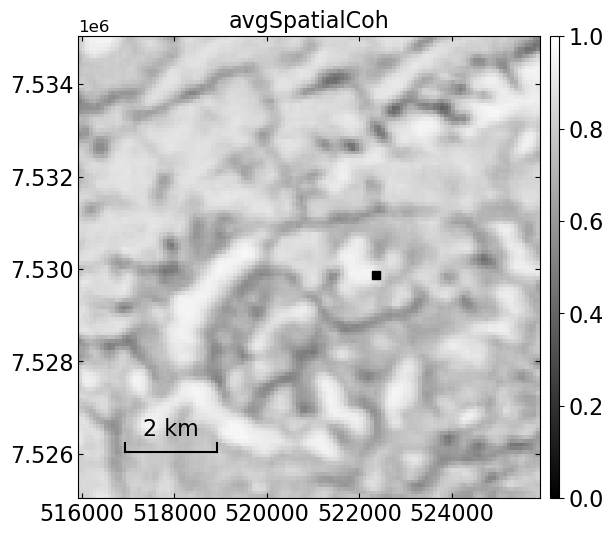

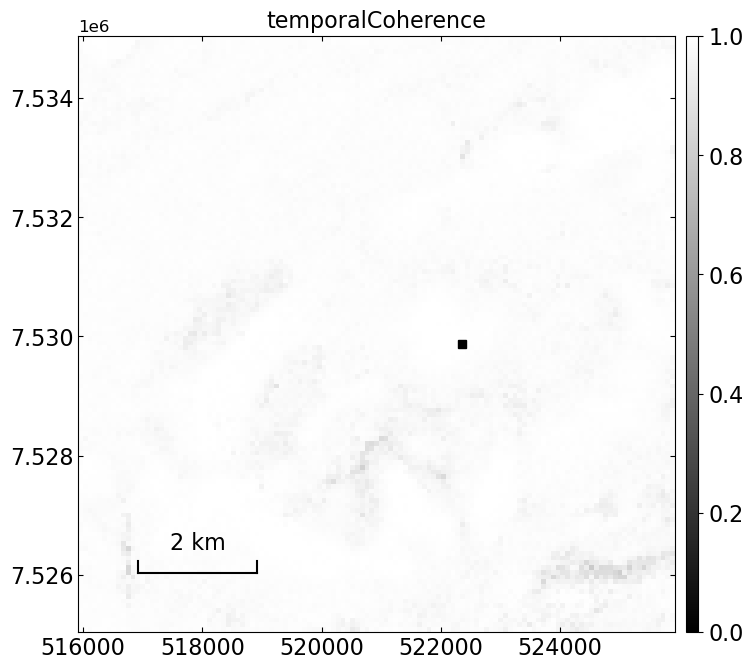

In [20]:
%matplotlib inline
scp_args = f"{mint_path}/temporalCoherence.h5 --dpi 600 --figsize 8 8 --outfile {plot_path}/temporal_coh.png"
view.main(scp_args.split())

input geometry file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/geometryGeo.h5
read /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/geometryGeo.h5 waterMask
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with zero value
delete exsited file: waterMask.h5
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (125, 125)           with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.0 secs.
view.py waterMask.h5 -c gray --noverbose


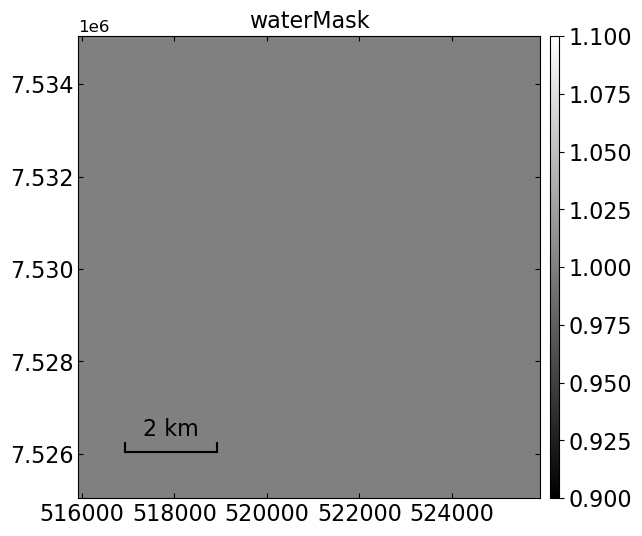

In [21]:
!generate_mask.py $inputs_path/geometryGeo.h5 waterMask --nonzero -o waterMask.h5
view.main('waterMask.h5 -c gray --noverbose'.split())

In [22]:
ts_h5 = f'{mint_path}/timeseries.h5'
!temporal_derivative.py $ts_h5

calculating the temporal derivative of timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries.h5
reading timeseries data
calculate the 1st derivative of timeseries data
create timeseries HDF5 file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_1stDiff.h5 with w mode
create dataset /timeseries of float32    in size of (21, 125, 125) with compression=None
create dataset /dates      of |S8        in size of (21,)
create dataset /bperp      of float32    in size of (21,)
finished writing to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_1stDiff.h5


run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries.h5 in float32 format
file size in y/x: (125, 125)
num of datasets in file timeseries.h5: 21
datasets to exclude (0):
[]
datasets to display (21):
['timeseries-20210607', 'timeseries-20210619', 'timeseries-20210701', 'timeseries-20210713', 'timeseries-20210725', 'timeseries-20210806', 'timeseries-20210818', 'timeseries-20210830', 'timeseries-20210911', 'timeseries-20210923', 'timeseries-20220602', 'timeseries-20220614', 'timeseries-20220626', 'timeseries-20220708', 'timeseries-20220720', 'timeseries-20220801', 'timeseries-20220813', 'timeseries-20220825', 'timeseries-20220906', 'timeseries-20220918', 'timeseries-20220930']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)

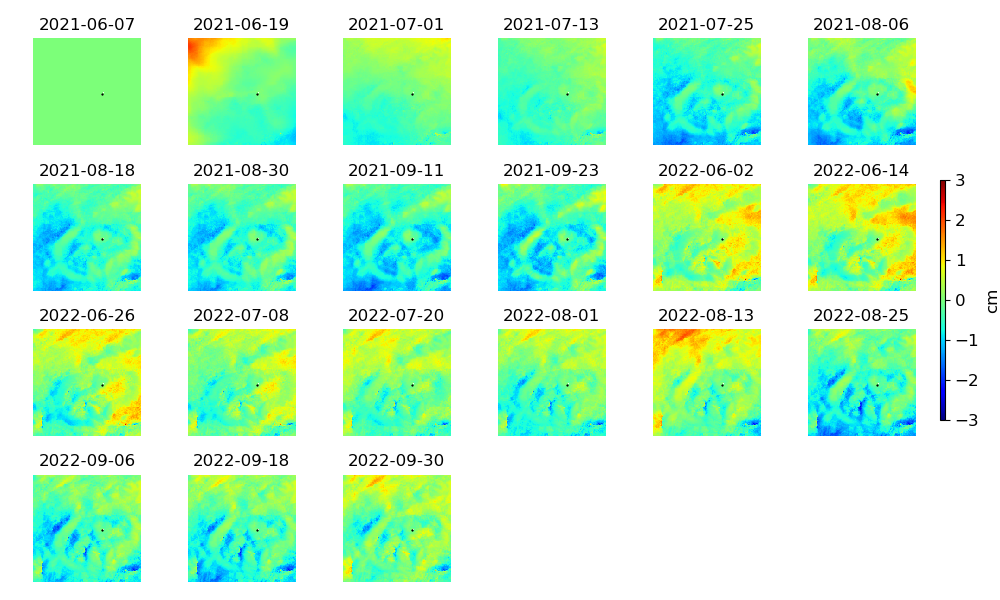

In [23]:
# Show the inverted phase history
%matplotlib widget
view.main(f'{mint_path}/timeseries.h5 -v -3 3 --noaxis --figsize 10 6'.split())

## 3.7. Correct for Tropospheric Propagation Delays (Optional)

**Run the `correct_troposphere` step**

- Uses ECMWF [ERA5 climate reanalysis pressure data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20)%20AND%20(%20%22Provider:%20Copernicus%20C3S%22%20))&text=pressure)
- CDS limits ECMWF archive requests to 50, so your requests may be queued until there is space.
    - https://cds.climate.copernicus.eu/live/queue

In [24]:
tropo_choice = asfn.select_parameter(["Perform Tropospheric Correction Step",
                                      "Skip Tropospheric Correction Step",
                                      "Delete Outputs of a Previous (possibly interrupted) Troposheric Correction and Rerun",
                                      "Delete Outputs of a Previous Troposheric Correction and Skip Troposheric Correction Now"])

display(tropo_choice)

RadioButtons(layout=Layout(min_width='800px'), options=('Perform Tropospheric Correction Step', 'Skip Troposph…

In [25]:
def set_troposhperic_correction_mintpy(config_path, method):
    config_path = Path(config_path)
    with open(config_path, 'r') as f:
        config = f.readlines()    
    config_update = config
    
    for i, l in enumerate(config):
        no_comment = l.split("#")[0]
        present = False
        if "mintpy.troposphericDelay.method=" in "".join(no_comment.split()):
            config_update[i] = f"mintpy.troposphericDelay.method = {method}"
            present = True
            break     
    if not present:
        config_update.append(f"\nmintpy.troposphericDelay.method = {method}")

    config_str = ""
    for l in config_update:
        config_str = f"{config_str}{l}"
    
    with open(config_path, 'w') as f:
        f.write(config_str)

In [26]:
correct_tropo = "Perform" in tropo_choice.value or "Rerun" in tropo_choice.value
era5_path = mint_path/"ERA5"
timeseries_era5_path = mint_path/"timeseries_ERA5.h5"
inputs_era5_path = mint_path/"inputs/ERA5.h5"

if "Delete" in tropo_choice.value:
    for f in [timeseries_era5_path, inputs_era5_path]:
        try:
            f.unlink()
        except FileNotFoundError:
            pass
    try:
        shutil.rmtree(era5_path)
    except FileNotFoundError:
        pass

if correct_tropo:
    set_troposhperic_correction_mintpy(config_path, "pyaps")
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_troposphere
else:
    set_troposhperic_correction_mintpy(config_path, "no")
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:48:32.312401--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
copy Sen_mintpy_config.txt to inputs   directory for backup.


In [27]:
ts_ERA5_h5 = f'{mint_path}/timeseries_ERA5.h5'

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5.h5 in float32 format
file size in y/x: (125, 125)
num of datasets in file timeseries_ERA5.h5: 21
datasets to exclude (0):
[]
datasets to display (21):
['timeseries-20210607', 'timeseries-20210619', 'timeseries-20210701', 'timeseries-20210713', 'timeseries-20210725', 'timeseries-20210806', 'timeseries-20210818', 'timeseries-20210830', 'timeseries-20210911', 'timeseries-20210923', 'timeseries-20220602', 'timeseries-20220614', 'timeseries-20220626', 'timeseries-20220708', 'timeseries-20220720', 'timeseries-20220801', 'timeseries-20220813', 'timeseries-20220825', 'timeseries-20220906', 'timeseries-20220918', 'timeseries-20220930']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 

/home/jovyan/.local/envs/NISAR_EA_Workshop_2024_1/lib/python3.9/site-packages/mintpy/view.py:1341: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


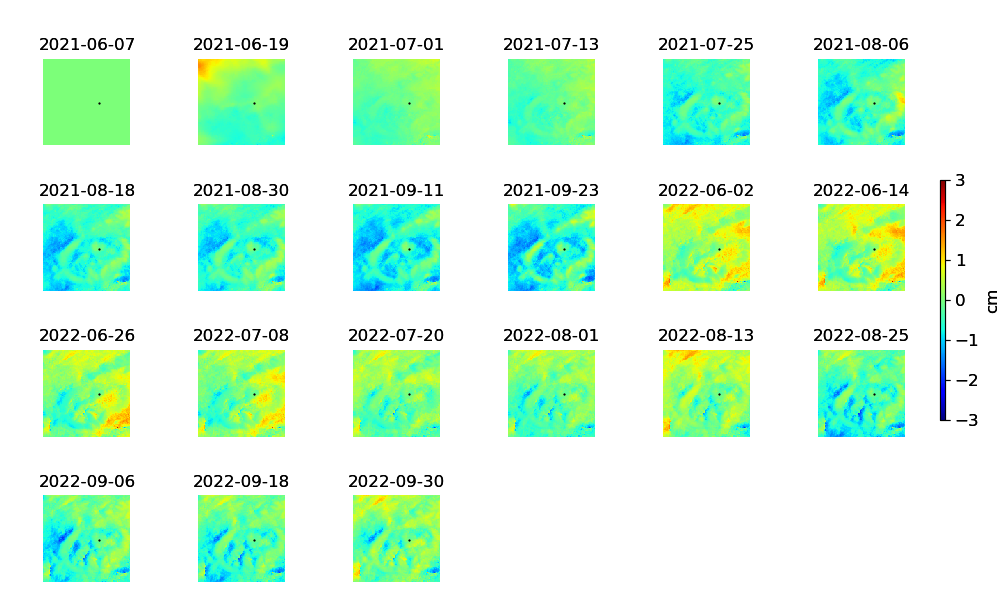

In [28]:
# Display the tropospheric-corrected time series
%matplotlib widget
view.main(f'{mint_path}/timeseries_ERA5.h5 -v -3 3 --noaxis --figsize 10 6'.split())

## 3.8. Correct for DEM Errors

**Run the `correct_topography` step**

In [29]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep deramp
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_topography

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:49:03.993758--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg


******************** step - deramp ********************
Remove for each acquisition a phase ramp: linear

remove_ramp.py 

In [30]:
ts_ERA5_demErr_h5 = f'{mint_path}/timeseries_ERA5_ramp_demErr.h5'
!temporal_derivative.py $ts_ERA5_demErr_h5

calculating the temporal derivative of timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr.h5
reading timeseries data
calculate the 1st derivative of timeseries data
create timeseries HDF5 file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr_1stDiff.h5 with w mode
create dataset /timeseries of float32    in size of (21, 125, 125) with compression=None
create dataset /dates      of |S8        in size of (21,)
create dataset /bperp      of float32    in size of (21,)
finished writing to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr_1stDiff.h5


run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr.h5 in float32 format
file size in y/x: (125, 125)
num of datasets in file timeseries_ERA5_ramp_demErr.h5: 21
datasets to exclude (0):
[]
datasets to display (21):
['timeseries-20210607', 'timeseries-20210619', 'timeseries-20210701', 'timeseries-20210713', 'timeseries-20210725', 'timeseries-20210806', 'timeseries-20210818', 'timeseries-20210830', 'timeseries-20210911', 'timeseries-20210923', 'timeseries-20220602', 'timeseries-20220614', 'timeseries-20220626', 'timeseries-20220708', 'timeseries-20220720', 'timeseries-20220801', 'timeseries-20220813', 'timeseries-20220825', 'timeseries-20220906', 'timeseries-20220918', 'timeseries-20220930']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.

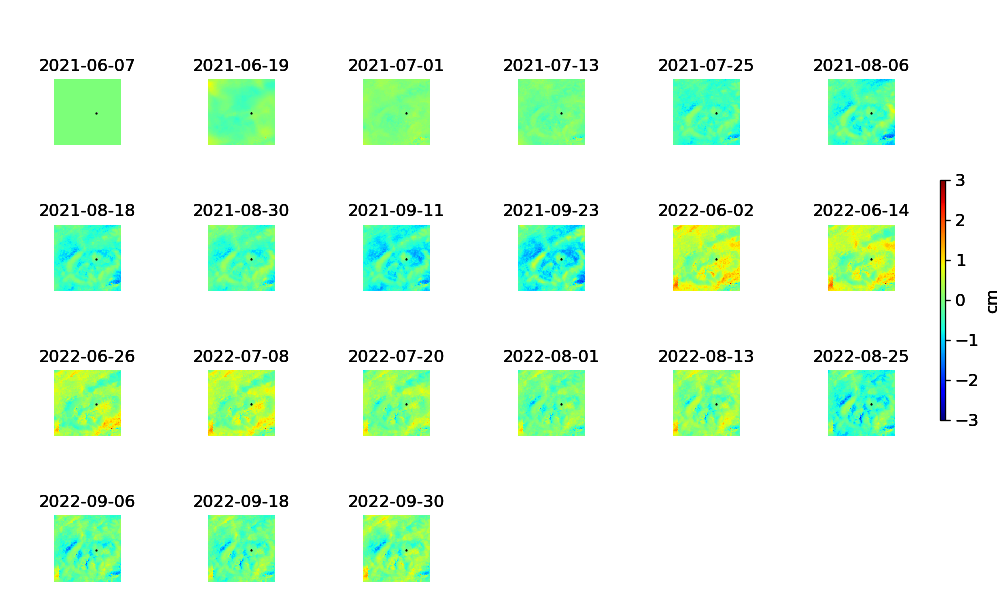

In [31]:
# Display the deramp time series
%matplotlib widget
view.main(f'{mint_path}/timeseries_ERA5_ramp_demErr.h5 -v -3 3 --noaxis --figsize 10 8'.split())
# view.main(f'{mint_path}/timeseries_ERA5_ramp_demErr_1stDiff.h5 -v -2 2 --noaxis --figsize 10 6'.split())

## 3.9. Calculate the Root Mean Square (RMS) of Residual Phase Time-Series for Each Acquisition

**Run the `residual_RMS` step**

- *reference: Yunjun et al. (2019, section 4.9 and 5.4)*
- To remove the long wavelength component in space, a phase ramp is removed for each acquisition
- Sets optimal reference date to date with min RMS
- Sets exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)

In [32]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep residual_RMS

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:49:15.334307--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg


******************** step - residual_RMS ********************

timeseries_rms.py timeseriesResidual.h5 -t /home/jovyan/insar_sbas_permafrost_chen/MintPy_

## 3.10. Reference the Entire Time-Series to One Date in Time

**Run the `reference_date` step**

- *reference: Yunjun et al. (2019, section 4.9)*

In [33]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_date

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:49:21.937515--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg


******************** step - reference_date ********************

reference_date.py -t /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg /home/jovy

## 3.11. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline 

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [34]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep velocity

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-01-18 03:49:27.255723--
Current directory: /home/jovyan/opensarlab_NISAR_EA_Workshop_2024_1_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Sen_mintpy_config
Go to work directory: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas
read custom template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/Sen_mintpy_config.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg
read default template file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr.h5 -t /home/jovyan/insar_

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 in float32 format
file size in y/x: (125, 125)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 7
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.0666819, 2.3223245] mm/year
display range: [0.0, 2.0] mm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image .

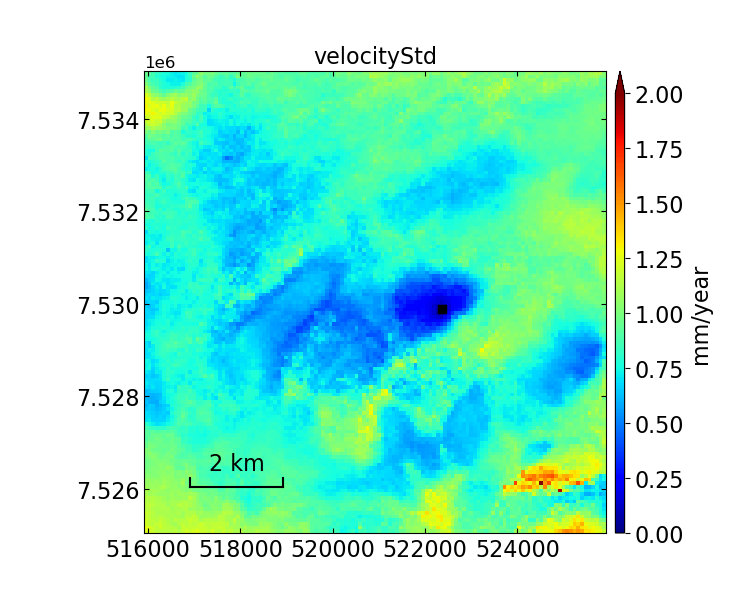

In [35]:
%matplotlib widget
view.main(f'{mint_path}/velocity.h5 velocityStd -u mm -v 0 2'.split())

In [36]:
# Calculate the amplitude of seasonal deformation which is double of the annual amplitude.
!image_math.py $mint_path/velocity.h5 '*' 2 --output $mint_path/season.h5

input is hyp3 velocity file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5
operation: file * 2.000000
create HDF5 file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/season.h5 with w mode
create dataset /velocity        of float32    in size of (125, 125)           with compression=None
create dataset /annualAmplitude of float32    in size of (125, 125)           with compression=None
create dataset /annualPhase     of float32    in size of (125, 125)           with compression=None
create dataset /velocityStd     of float32    in size of (125, 125)           with compression=None
create dataset /intercept       of float32    in size of (125, 125)           with compression=None
create dataset /interceptStd    of float32    in size of (125, 125)           with compression=None
create dataset /residue         of float32    in size of (125, 125)           with compression=None
finished writing to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/season.h5


view.py /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 velocity --dem /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --ylabel-rot 90 --noverbose --noscalebar -v -3 3
view.py /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/season.h5 annualAmplitude --dem /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --ylabel-rot 90 --noverbose --noscalebar -v -5 5


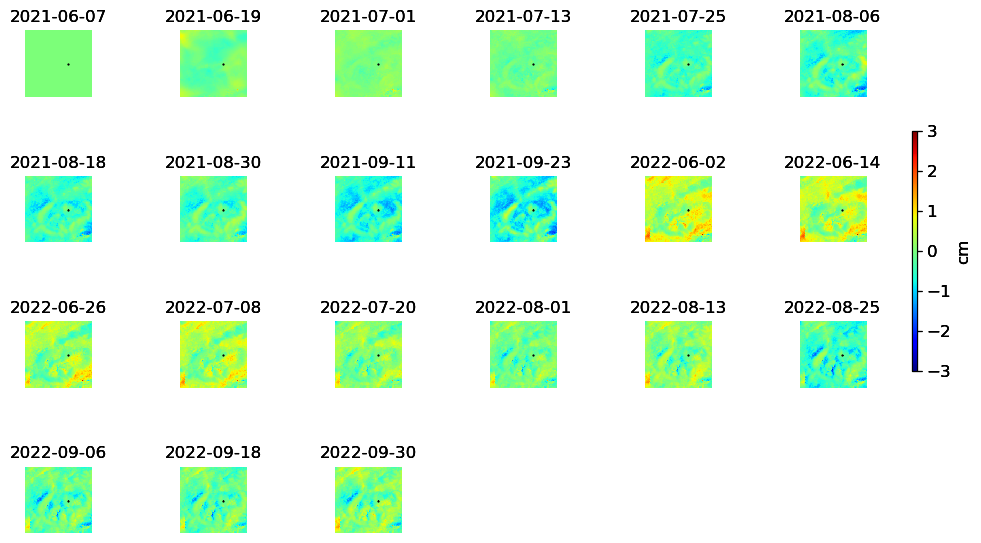

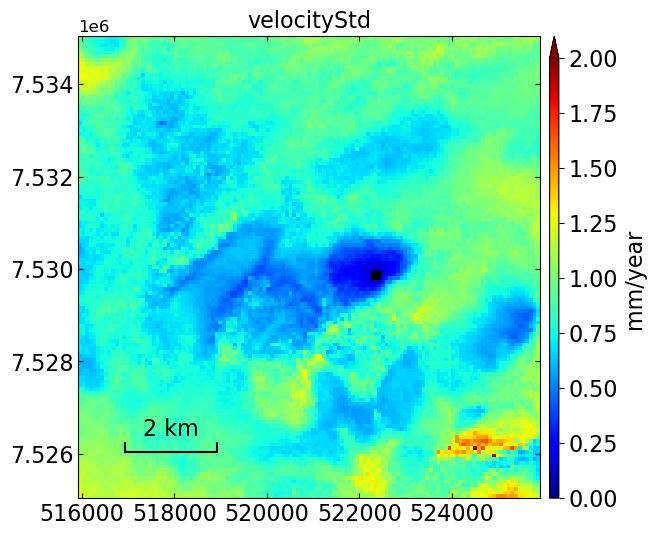

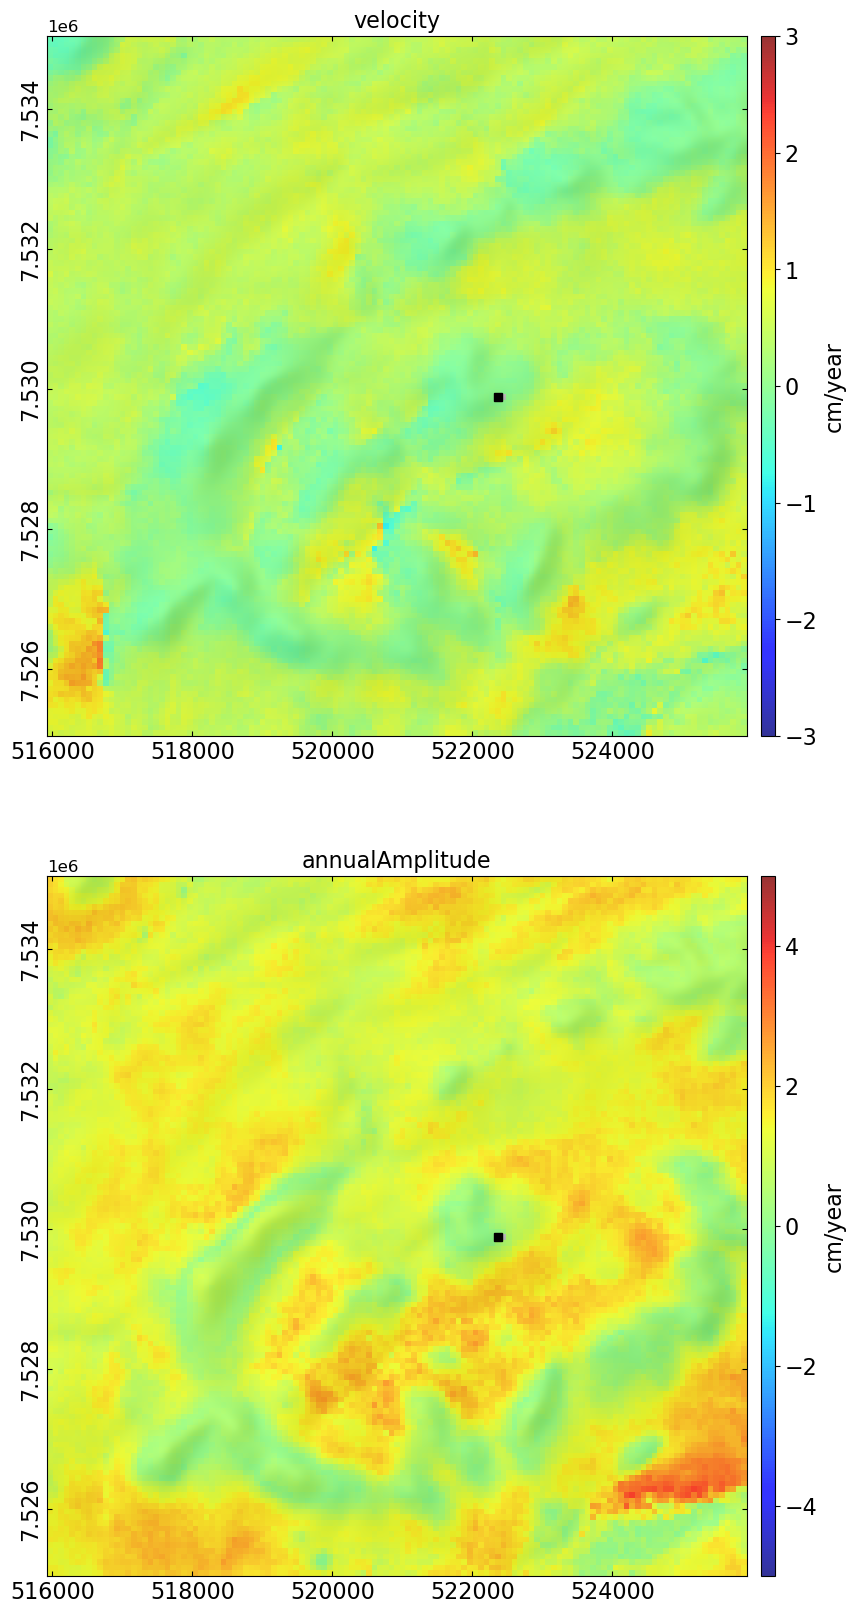

In [37]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# from cartopy import crs as ccrs
from mintpy.view import prep_slice, plot_slice

%matplotlib inline
# view.py options
opt = f'--dem {inputs_path}/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour --ylabel-rot 90 --noverbose --noscalebar '
cmd_list = [
    f'view.py {mint_path}/velocity.h5 velocity {opt} -v -3 3',
    f'view.py {mint_path}/season.h5 annualAmplitude {opt} -v -5 5',
    # f'view.py {mint_path}/velocityRaw.h5 annualPhase {opt} -c cmy -v 0 3.14',
]

# plot using matplotlib & mintpy.view
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[30, 20])
for ax, cmd in zip(axs.flatten(), cmd_list):
    data, atr, inps = prep_slice(cmd)
    plot_slice(ax, data, atr, inps)
plt.show()

## 3.12. Plot the Cumulative Displacement Map and Point Displacement Time Series

- Use the `Time` bar below the Cumulative Displacement Map to view displacements for different time periods
- Click on the Cumulative Displacement Map to select points for displaying Point Displacement Time-Series

In [38]:
demErr = 'timeseries_ERA5_ramp_demErr.h5' if correct_tropo else 'timeseries_ramp_demErr.h5'
ts_demErr = mint_path/f'{demErr}'
temp_coh_msk_h5 = mint_path/'maskTempCoh.h5'

/home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr.h5 -d /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/geometryGeo.h5 --poly 1 --periodic 1.0 --ylim -4 4 --figsize 10 7 -o /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/displacement_ts --outfile /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/displacement_ts.pdf
tsview.py /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr.h5 -d /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/inputs/geometryGeo.h5 --poly 1 --periodic 1.0 --ylim -4 4 --figsize 10 7 -o /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/displacement_ts --outfile /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/displacement_ts.pdf
open timeseries file: timeseries_ERA5_ramp_demErr.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0

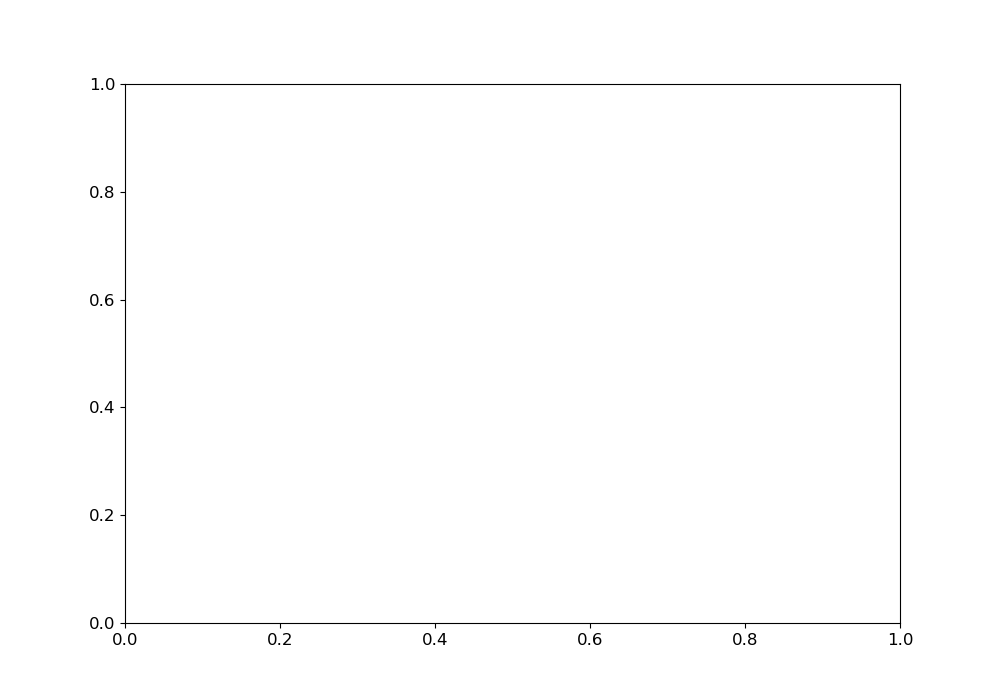

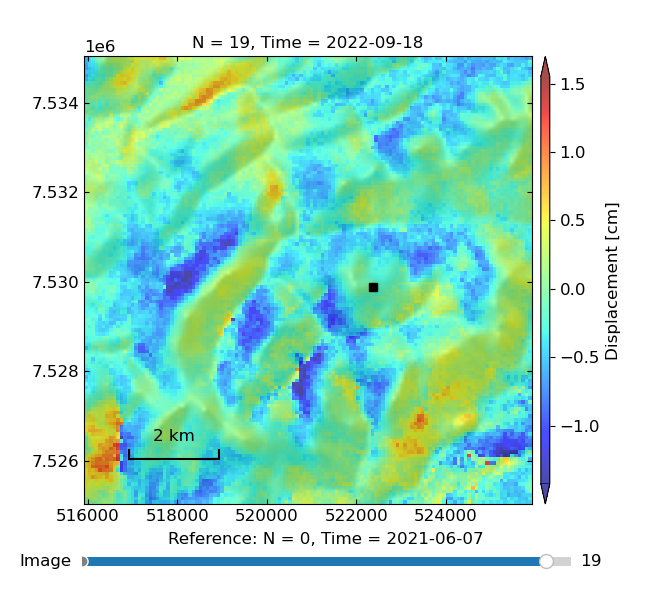

In [39]:
%matplotlib widget
scp_args = f'{ts_demErr} -d {mint_path}/inputs/geometryGeo.h5 --poly 1 --periodic 1.0 --ylim -4 4 --figsize 10 7 -o {mint_path}/displacement_ts --outfile {mint_path}/displacement_ts.pdf'
print(scp_args)
tsview.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

# 4. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 4.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 4.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is coherence file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/avgSpatialCoh.h5 in float32 format
file size in y/x: (125, 125)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.38290286, 0.9683592] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
save figure to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/plots/avg_spatial_coh.png with dpi=600
showing .

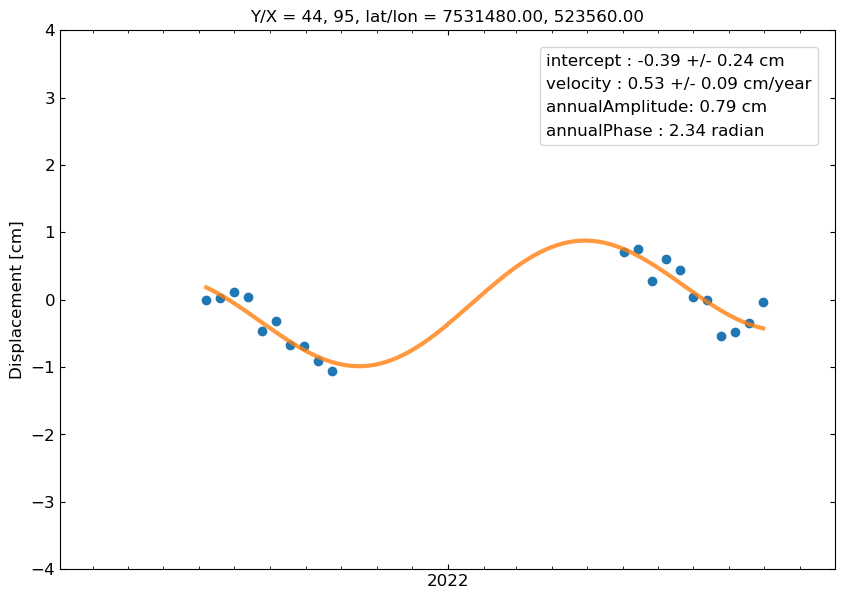

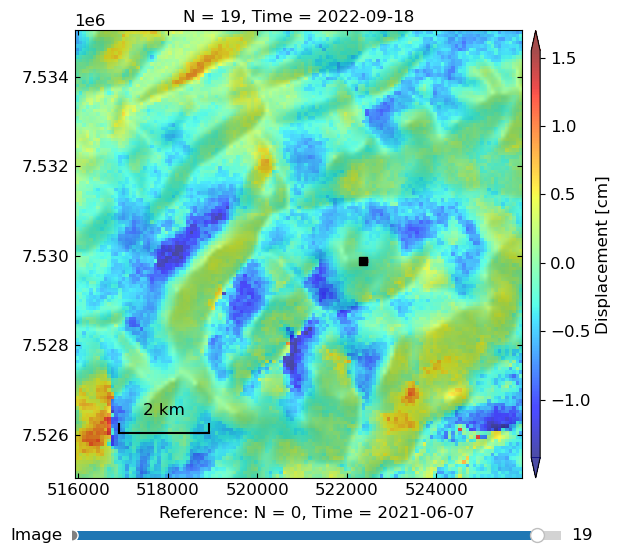

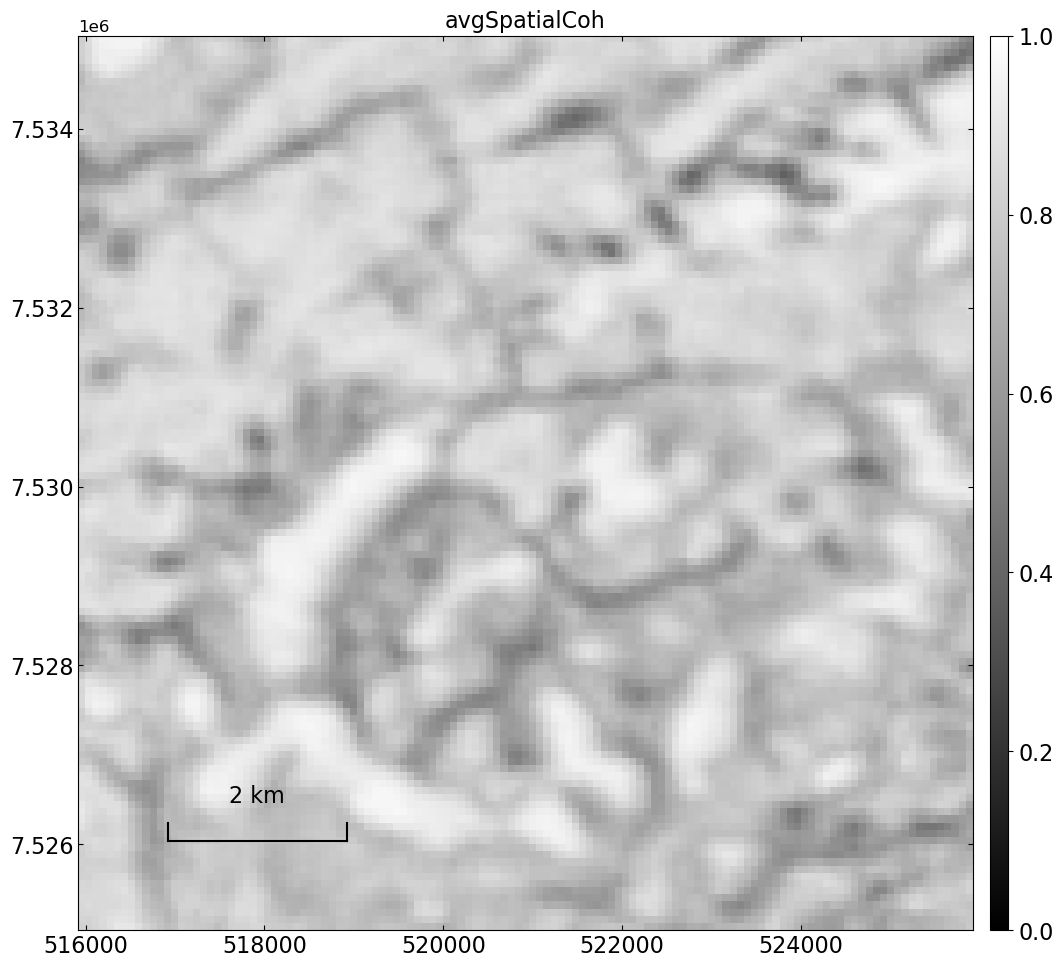

In [40]:
%matplotlib inline
scp_args = f"{mint_path}/avgSpatialCoh.h5 --dpi 600 --figsize 12 12 --outfile {plot_path}/avg_spatial_coh.png"
view.main(scp_args.split())

### 4.1.2. Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is temporalCoherence file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/temporalCoherence.h5 in float32 format
file size in y/x: (125, 125)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.79279655, 1.0] 1
display range: [0.6, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
save figure to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/plots

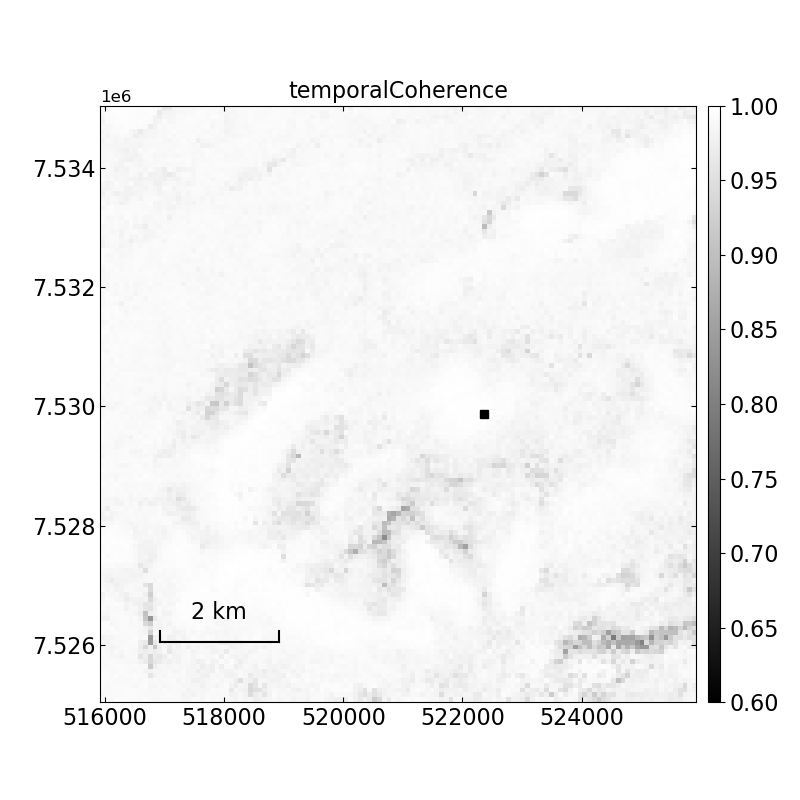

In [41]:
%matplotlib widget
scp_args = f"{mint_path}/temporalCoherence.h5 -v 0.6 1 --dpi 600 --figsize 8 8 --outfile {plot_path}/temporal_coh.png"
view.main(scp_args.split())

## 4.2. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 in float32 format
file size in y/x: (125, 125)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 7
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.0066681895, 0.23223245] cm/year
display range: [0.0, 0.2] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2

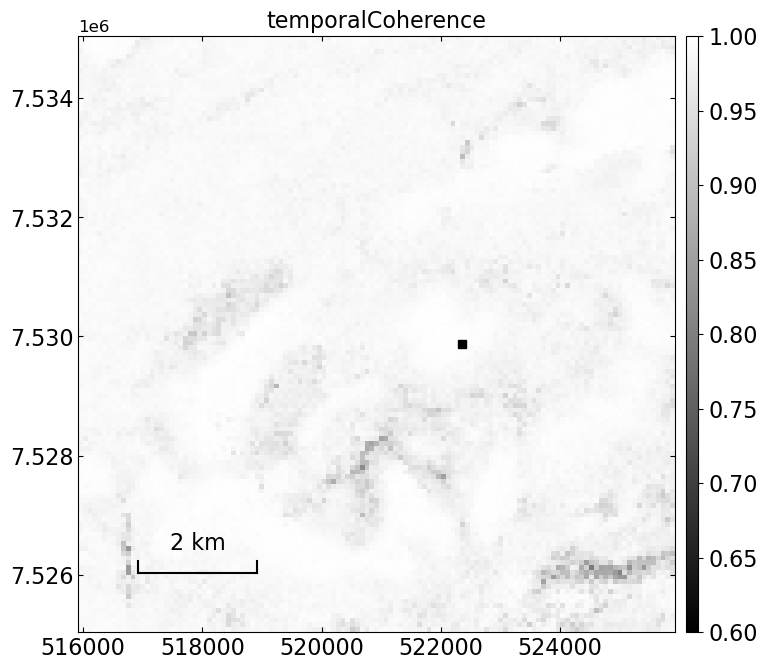

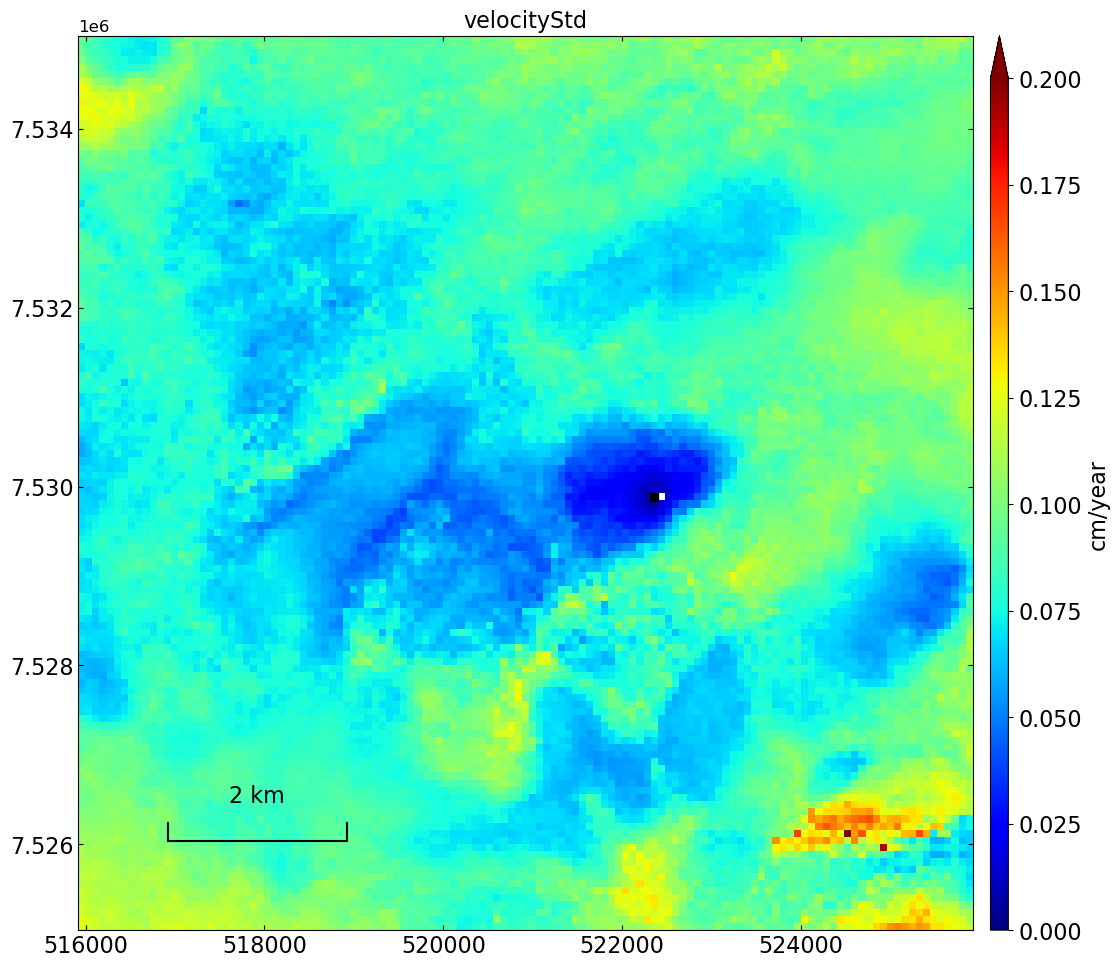

In [42]:
%matplotlib inline
scp_args = f'{mint_path}/velocity.h5 velocityStd -v 0 0.2 --dpi 600 --figsize 12 12 --outfile {plot_path}/velocity_err.png'
# scp_args = f'{mint_path}/velocity.h5 interceptStd -v 0 0.5 --dpi 600 --figsize 12 12 --outfile {plot_path}/season_err.png'
view.main(scp_args.split())

Note that the plot above is the velocity error, not the velocity. The errors generally increases with distance from the reference point and can also increase for points with elevations different from the reference point if topographically correlated water vapor variations are especially strong in the area.

# 5. Generate products of coherence, velocity, and total displacement Geotiffs

**Create directories in which to store output we will create in upcoming steps**

In [43]:
geotiff_path = mint_path/'GeoTiffs'
geotiff_path.mkdir(exist_ok=True)

disp_path = geotiff_path/'displacement_maps'
disp_path.mkdir(exist_ok=True)

In [44]:
with h5py.File(ts_demErr, "r") as f:
    dates = f["date"][()]
    date_list = [str(int(d)) for d in dates]
date_list
with h5py.File(ts_demErr, 'r') as f:
    unw_path = f.attrs['FILE_PATH']
ds_unw = rasterio.open(unw_path, 'r', driver='GTiff')

for i, d in enumerate(tqdm(date_list)):
    # date_range = f'{date_list[i]}'
    cmd = f'view.py {ts_demErr} {date_list[i]} --notitle --notick --noaxis'
    data, _, _ = mintpy.view.prep_slice(cmd)
    data = data / 100 # cm -> meters
        
    with rasterio.open(f'{disp_path}/defo_{date_list[i]}.tif', 'w', driver='GTiff',
                  height = data.shape[0], width = data.shape[1],
                  count=1, dtype=str(data.dtype),
                  crs=ds_unw.read_crs(),
                  transform=ds_unw.transform,
                  nodata=np.nan) as ds:
        ds.write(data.astype(rasterio.float32), 1)

  0%|          | 0/21 [00:00<?, ?it/s]

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/timeseries_ERA5_ramp_demErr.h5 in float32 format
file size in y/x: (125, 125)
input dataset: "['20210607']"
num of datasets in file timeseries_ERA5_ramp_demErr.h5: 21
datasets to exclude (0):
[]
datasets to display (1):
['timeseries-20210607']
data   coverage in y/x: (0, 0, 125, 125)
subset coverage in y/x: (0, 0, 125, 125)
data   coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
subset coverage in lat/lon: (515920.0, 7535040.0, 525920.0, 7525040.0)
------------------------------------------------------------------------
colormap: jet
figure title: timeseries-20210607_ERA5_ramp_demErr
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
data    range: [0.0, 0.0] cm
display range: [0.0, 0.0] cm
run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/t

**Save the average spatial coherence and temporal coherence geotiff**

In [45]:
!save_gdal.py $mint_path/avgSpatialCoh.h5 --of GTIFF -o $geotiff_path/avgSpatialCoh.tif
!save_gdal.py $mint_path/temporalCoherence.h5 --of GTIFF -o $geotiff_path/TemporalCoherence.tif

read data from file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/avgSpatialCoh.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 125, 125
raster transform info: (515920.0, 80.0, 0, 7535040.0, 0, -80.0)
write data to raster band
set projection as: EPSG 32603
finished writing to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/GeoTiffs/avgSpatialCoh.tif
read data from file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/temporalCoherence.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 125, 125
raster transform info: (515920.0, 80.0, 0, 7535040.0, 0, -80.0)
write data to raster band
set projection as: EPSG 32603
finished writing to /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/GeoTiffs/TemporalCoherence.tif


**Save the velocity geotiff**

In [46]:
velocity_name = "velocity"
vel_h5 = mint_path/f'{velocity_name}.h5'
vel_msk_h5 = mint_path/f'{velocity_name}_msk.h5'
vel_tiff = geotiff_path/f'{velocity_name}_msk.tif'
amp_tiff = geotiff_path/'season_amplitude_msk.tif'
amp_tiff_2 = geotiff_path/'season_amplitude_msk_2.tif'
# vel_kmz = geotiff_path/f'{velocity_name}_msk.kmz'

!mask.py $vel_h5 -m $temp_coh_msk_h5
!save_gdal.py $vel_msk_h5 --of GTIFF -o $vel_tiff
!save_gdal.py $vel_msk_h5 -d annualAmplitude --of GTIFF -o $amp_tiff
!gdal_calc.py -A $amp_tiff --outfile=$amp_tiff_2 --calc="A*2" --NoDataValue=0
!rm $amp_tiff

masking velocity        from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
masking annualAmplitude from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
masking annualPhase     from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
masking velocityStd     from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
masking intercept       from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
masking interceptStd    from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
masking residue         from /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity.h5 ...
create HDF5 file: /home/jovyan/insar_sbas_permafrost_chen/MintPy_sbas/velocity_msk.h5 with w mode
create dataset /velocity        of float32    in size of (125, 125)           with compression=None
create dataset /annualAmplitude of float32    in size of (125, 125)           with compression=None
create dataset /annualP

# Reference material

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

*MintPy_Time_Series_From_Prepared_Data_Stack.ipynb - Version 0.3.0 - January 2023*

*Version Changes*

- *store CDS credentials in `~/.cdsapirc` instead of in pyaps3 config*
- *update pyaps3 config with CDS credentials in the notebook*
- *add config option to use a local dask cluster for multithreading*
    - *interferogram inversion*
    - *dem error correction*